In [368]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import MaskablePPO
from stable_baselines3.common.monitor import Monitor
from typing import Dict, Any, List, Tuple, Optional
import gymnasium as gym   
from gymnasium import spaces 
import numpy as np
import networkx as nx
import random
import math

In [369]:
# ------------------------- Energy model -------------------------

def energy_for_edge(edge_data: Dict[str, Any], vehicle_params: Dict[str, float], speed_m_s: Optional[float] = None) -> float:
    """Estimate kWh required to traverse an edge.
    This is the same physical model you provided, with small safety clamps.
    """
    m = vehicle_params.get('mass_kg', 1800)
    g = 9.80665
    rho = 1.225
    CdA = vehicle_params.get('CdA', 0.62)
    Cr = vehicle_params.get('Cr', 0.015)
    regen = vehicle_params.get('regen_eff', 0.6)

    length = float(edge_data.get('length', 100.0))
    slope_deg = float(edge_data.get('slope_deg', 0.0))
    theta = np.radians(slope_deg)

    # infer speed
    if speed_m_s is None:
        speed_kph = edge_data.get('speed_kph', None)
        if speed_kph is None:
            travel_time = edge_data.get('travel_time', None)
            if travel_time is None or travel_time <= 0:
                # default to 50 km/h
                speed_m_s = 50.0 / 3.6
            else:
                speed_m_s = length / max(travel_time, 1e-6)
        else:
            speed_m_s = float(speed_kph) * 1000.0 / 3600.0

    grade_force = m * g * math.sin(theta)
    rolling_force = m * g * math.cos(theta) * Cr
    aero_force = 0.5 * rho * CdA * (speed_m_s ** 2)

    resistive_force = grade_force + rolling_force + aero_force
    energy_j = resistive_force * length

    stop_prob = float(edge_data.get('stop_prob', 0.0))
    accel_energy_j = stop_prob * 0.5 * m * (speed_m_s ** 2) * (1.0 - regen)

    congestion = float(edge_data.get('congestion_factor', 1.0))
    congestion_loss_j = length * max(congestion - 1.0, 0.0) * m * g * 0.01

    total_j = energy_j + accel_energy_j + congestion_loss_j

    total_kwh = total_j / 3.6e6

    # allow small negative to represent regen credit but clamp extreme values
    if total_kwh < -0.05:
        total_kwh = -0.05
    return float(total_kwh)



In [370]:
# -------------------- Node embeddings (spectral) --------------------

def compute_spectral_embeddings(G: nx.Graph, dim: int = 8, normalized: bool = True, add_degree: bool = True) -> np.ndarray:
    """Compute a simple spectral embedding for nodes.
    Returns an array of shape (n_nodes, dim (+1 if degree appended)).
    Uses top `dim` eigenvectors of normalized Laplacian.
    """
    A = nx.to_scipy_sparse_array(G, nodelist=list(G.nodes()), format='csr')
    # degree matrix
    degs = np.asarray(A.sum(axis=1)).flatten()
    n = A.shape[0]

    # build normalized Laplacian L = I - D^{-1/2} A D^{-1/2}
    with np.errstate(divide='ignore'):
        d_inv_sqrt = np.power(degs, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    # compute normalized adjacency
    A_norm = D_inv_sqrt @ A.toarray() @ D_inv_sqrt
    L = np.eye(n) - A_norm

    # compute eigenvectors of L; smallest non-zero eigenvectors provide embedding
    try:
        eigvals, eigvecs = np.linalg.eigh(L)
    except Exception:
        # fallback: use random embeddings
        emb = np.random.randn(n, dim)
        if add_degree:
            deg_col = (degs.reshape(-1, 1) / (np.max(degs) + 1e-6))
            emb = np.hstack([emb, deg_col])
        return emb.astype(np.float32)

    # sort eigenvectors by eigenvalue ascending
    idx = np.argsort(eigvals)
    # skip the first 0 eigenvector (constant) if present
    start = 1 if eigvals[idx[0]] < 1e-8 else 0
    vecs = eigvecs[:, idx[start:start + dim]]

    emb = vecs
    if add_degree:
        deg_col = (degs.reshape(-1, 1) / (np.max(degs) + 1e-6))
        emb = np.hstack([emb, deg_col])

    # normalize embeddings
    emb = emb.astype(np.float32)
    emb = (emb - emb.mean(axis=0, keepdims=True)) / (emb.std(axis=0, keepdims=True) + 1e-8)
    return emb


In [374]:
class EVPathEnv(gym.Env):
    """
    Environment for single EV path optimization with partial road closures.
    Ensures every episode has a solvable path and encourages longer, energy-efficient routes.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, G: nx.Graph, vehicle_params: Dict[str, Any], embeddings: Optional[np.ndarray] = None,
                 seed: int = 0, debug: bool = False):
        super().__init__()
        self.G = G
        self.vehicle_params = vehicle_params
        self.rng = np.random.default_rng(seed)
        self.debug = debug

        self.nodes = list(G.nodes())
        self.node_to_idx = {n: i for i, n in enumerate(self.nodes)}
        self.n_nodes = len(self.nodes)
        self.max_episode_steps = self.n_nodes * 10  # increased to allow longer episodes

        # Cache all-pairs shortest paths for distance features
        self.shortest_paths = dict(nx.all_pairs_shortest_path_length(self.G))

        # Neighbor index mapping
        self.neighbors: List[List[int]] = []
        max_deg = 0
        for u in self.nodes:
            nbrs = [self.node_to_idx[v] for v in G.neighbors(u)]
            self.neighbors.append(nbrs)
            max_deg = max(max_deg, len(nbrs))
        self.max_degree = max_deg if max_deg > 0 else 1

        # Embeddings
        if embeddings is None:
            self.embeddings = compute_spectral_embeddings(G, dim=6)
        else:
            self.embeddings = embeddings
        self.embedding_dim = self.embeddings.shape[1]

        # Observation + action spaces
        obs_dim = self.embedding_dim * 2 + 2 + self.max_degree  # add neighbor distances
        self.observation_space = gym.spaces.Dict({
            "observation": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32),
            "action_mask": gym.spaces.Box(low=0, high=1, shape=(self.max_degree,), dtype=np.int8)
        })
        self.action_space = gym.spaces.Discrete(self.max_degree)

        # Energy + tracking
        self.battery_capacity_kwh = vehicle_params.get('battery_capacity_kwh', 75.0)
        self.episode = 0
        self.success_history = []

        # Initialize open roads graph
        self.rebuild_open_roads_graph()

    # ----------------------------------------------------
    # Helper to rebuild the subgraph of open roads
    # ----------------------------------------------------
    def rebuild_open_roads_graph(self):
        self.open_roads_graph = nx.Graph()
        self.open_roads_graph.add_nodes_from(self.G)
        open_edges = [(u, v, d) for u, v, d in self.G.edges(data=True) if d.get("status", "open") == "open"]
        self.open_roads_graph.add_edges_from(open_edges)

    # ----------------------------------------------------
    # Reset function: guarantees solvable (src, dst)
    # ----------------------------------------------------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.episode += 1

        # Ensure open roads graph is connected enough
        components = [c for c in nx.connected_components(self.open_roads_graph) if len(c) > 1]
        if not components:
            if self.debug:
                print("[WARN] Graph too disconnected — reopening some roads.")
            for u, v, data in self.G.edges(data=True):
                if data.get("status") == "closed" and random.random() < 0.3:
                    data["status"] = "open"
            self.rebuild_open_roads_graph()
            components = [c for c in nx.connected_components(self.open_roads_graph) if len(c) > 1]

        # Robust src/dst selection with min distance
        min_dist = max(2, self.n_nodes // 4)  # minimum steps to encourage longer episodes
        attempts = 0
        while True:
            self.src = random.choice(self.nodes)
            if self.src in self.open_roads_graph:
                reachable = list(nx.node_connected_component(self.open_roads_graph, self.src))
                possible_dst = [n for n in reachable
                                if n != self.src
                                and self.shortest_paths[self.src].get(n, 0) >= min_dist]
                if possible_dst:
                    self.dst = random.choice(possible_dst)
                    break
            attempts += 1
            if attempts > self.n_nodes * 5:
                raise RuntimeError("No valid start–destination pair found in open roads graph!")

        # Reset episode state
        self.current = self.src
        self.total_energy = 0.0
        self.visited = {self.src}
        self.steps = 0

        return self._get_dict_obs(), {}

    # ----------------------------------------------------
    # Observation helpers
    # ----------------------------------------------------
    def _make_obs_vec(self) -> np.ndarray:
        current_idx = self.node_to_idx[self.current]
        dst_idx = self.node_to_idx[self.dst]
        cur_emb = self.embeddings[current_idx]
        dst_emb = self.embeddings[dst_idx]

        # Global features
        energy_fraction = max(0.0, (self.battery_capacity_kwh - self.total_energy) / self.battery_capacity_kwh)
        dist_to_dst = self.shortest_paths[self.current].get(self.dst, self.n_nodes)
        dist_norm = dist_to_dst / self.n_nodes

        # Neighbor features
        nbrs = self.neighbors[current_idx]
        nbr_dist_to_dst = np.zeros(self.max_degree, dtype=np.float32)
        for i, nbr_idx in enumerate(nbrs):
            nbr_node = self.nodes[nbr_idx]
            nbr_dist = self.shortest_paths[nbr_node].get(self.dst, self.n_nodes)
            nbr_dist_to_dst[i] = nbr_dist / self.n_nodes  # normalize

        # Concatenate all features
        obs_vec = np.concatenate([cur_emb, dst_emb, np.array([energy_fraction, dist_norm], dtype=np.float32), nbr_dist_to_dst])
        return obs_vec

    def _get_dict_obs(self) -> Dict:
        return {"observation": self._make_obs_vec(), "action_mask": self._get_action_mask()}

    def _get_action_mask(self) -> np.ndarray:
        mask = np.zeros(self.max_degree, dtype=np.int8)
        current_idx = self.node_to_idx[self.current]
        nbrs = self.neighbors[current_idx]
        for i, nbr_idx in enumerate(nbrs):
            nbr_node = self.nodes[nbr_idx]
            edge_data = self.G[self.current][nbr_node]
            if edge_data.get("status") != "closed":
                mask[i] = 1
        return mask

    # ----------------------------------------------------
    # Step function
    # ----------------------------------------------------
    def step(self, action: int):
        self.steps += 1

        nbrs = self.neighbors[self.node_to_idx[self.current]]

        # Check if action is within available neighbors
        if action >= len(nbrs) or self.G[self.current][self.nodes[nbrs[action]]].get("status") == "closed":
            reward = -2.0
            terminated, truncated = True, False
            self.success_history.append(0)
            return self._get_dict_obs(), reward, terminated, truncated, {"error": "Invalid action"}

        next_idx = nbrs[action]
        next_node = self.nodes[next_idx]

        # Compute energy usage
        edge_attrs = self.G[self.current][next_node]
        e_kwh = energy_for_edge(edge_attrs, self.vehicle_params)
        self.total_energy += e_kwh

        # Distance progress
        dist_before = self.shortest_paths[self.current].get(self.dst, self.n_nodes)
        dist_after = self.shortest_paths[next_node].get(self.dst, self.n_nodes)
        dist_improvement = dist_before - dist_after

        # Reward shaping
        w_d, w_e, w_l, w_s = 1.0, 0.3, 0.3, 0.05
        reward = w_d * dist_improvement - w_e * e_kwh - w_s
        if next_node in self.visited:
            reward -= w_l

        # Update state
        self.current = next_node
        self.visited.add(next_node)

        # Terminal conditions
        terminated = (self.current == self.dst)
        truncated = (self.steps >= self.max_episode_steps) or (self.total_energy >= self.battery_capacity_kwh)

        if terminated:
            reward += 10.0
            self.success_history.append(1)
        elif truncated:
            reward -= 5.0
            self.success_history.append(0)

        return self._get_dict_obs(), reward, terminated, truncated, {}

    # ----------------------------------------------------
    # Render
    # ----------------------------------------------------
    def render(self, mode='human'):
        energy_frac = (self.battery_capacity_kwh - self.total_energy) / self.battery_capacity_kwh
        print(f"Step: {self.steps}, Current: {self.current}, Dst: {self.dst}, "
              f"Energy Used: {self.total_energy:.2f}kWh, Battery: {energy_frac:.2%}")

In [228]:
# ----------------------- Training helpers & debug -----------------------


class TrainingDebugCallback(BaseCallback):
    """Callback that prints and logs custom training information every `print_freq` calls to _on_step.
    It also runs a quick eval every `eval_freq` steps.
    """
    def __init__(self, eval_env: Optional[gym.Env] = None, print_freq: int = 1, eval_freq: int = 10000, verbose: int = 0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.print_freq = print_freq
        self.eval_freq = eval_freq
        self._n_calls = 0

    def _on_step(self) -> bool:
        self._n_calls += 1
        # print every `print_freq` calls
        if self._n_calls % self.print_freq == 0:
            # Attempt to print some SB3 log values if available
            try:
                vals = self.logger.name_to_value
                # pick a few useful scalars if present
                ev = vals.get('train/explained_variance', None)
                vl = vals.get('train/value_loss', None)
                pl = vals.get('train/policy_gradient_loss', None)
                if ev is not None or vl is not None or pl is not None:
                    print(f"[Callback] steps={self.num_timesteps} ev={ev} value_loss={vl} pg_loss={pl}")
            except Exception:
                pass

        if self.eval_env is not None and (self.num_timesteps % self.eval_freq == 0) and (self.num_timesteps > 0):
            mean_reward, std_reward = evaluate_policy(self.model, self.eval_env, n_eval_episodes=3, deterministic=True)
            print(f"[Eval] timesteps={self.num_timesteps} mean_reward={mean_reward:.4f} std={std_reward:.4f}")
        return True



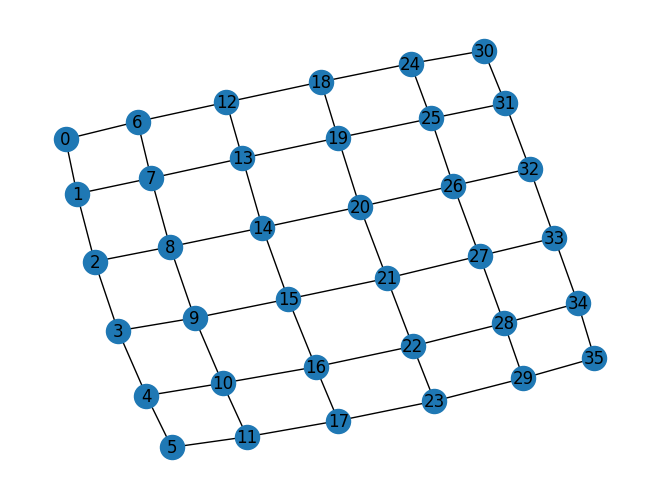

In [ ]:
# Example usage -- you must define `road_network` and `update_dynamic_edge_states` in your project.
# For demonstration we'll build a small random graph.
G = nx.grid_2d_graph(6, 6)
G = nx.convert_node_labels_to_integers(G)
# add some dummy edge attributes
for u, v in G.edges():
    G[u][v]['length'] = random.uniform(50, 500)
    G[u][v]['slope_deg'] = random.uniform(-5, 5)
    G[u][v]['congestion_factor'] = random.uniform(1.0, 1.5)
    G[u][v]['stop_prob'] = random.choice([0.0, 0.2])
    G[u][v]['speed_kph'] = random.choice([30, 50])
    G[u][v]['status'] = "open" if random.random() > 0.05 else "closed"

vehicle_params = {
    'mass_kg': 1850,
    'CdA': 0.62,
    'Cr': 0.015,
    'regen_eff': 0.65,
}

pos = nx.spring_layout(G,seed=42)
nx.draw(G,pos, with_labels=True)
import matplotlib.pyplot as plt 
plt.show()

In [ ]:
vehicle_params = {
    'mass_kg': 1850,
    'CdA': 0.62,
    'Cr': 0.015,
    'regen_eff': 0.65,
    'battery_capacity_kwh': 75.0,
}

# 2. Setup the environment (this part is largely the same)
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.monitor import Monitor

embeddings = compute_spectral_embeddings(G, dim=6)

# This helper function is required for the ActionMasker wrapper
def extract_action_masks(env: EVPathEnv) -> np.ndarray:
    return env._get_action_mask()

def make_env():
    env = EVPathEnv(G, vehicle_params, embeddings=embeddings, debug=False)
    env = ActionMasker(env, extract_action_masks)
    env = Monitor(env)
    return env

vec_env = DummyVecEnv([make_env])

# 3. Update the MaskablePPO model definition
model = MaskablePPO(
    policy="MultiInputPolicy",
    env=vec_env,
    verbose=1,
    device="cpu",
    learning_rate=1e-4,
    ent_coef=0.005,
    n_steps=1024, 
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    clip_range=0.2,
    gae_lambda=0.95,
    vf_coef=0.5
)

# 4. Train the model (from scratch)
model.learn(total_timesteps=300_000)
model.save("ppo_ev_robust_v1")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 140      |
|    ep_rew_mean     | -26.7    |
| time/              |          |
|    fps             | 765      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 125         |
|    ep_rew_mean          | -21.8       |
| time/                   |             |
|    fps                  | 639         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008127466 |
|    clip_fraction        | 0.0235      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | -0.0129     |
|    learning

In [315]:
# Quick evaluation
mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=5, deterministic=True)
print(f"Final eval mean_reward={mean_reward:.4f} std={std_reward:.4f}")


Final eval mean_reward=10.3624 std=10.0939


In [333]:
print("--- Starting Demo Rollout ---")
# Load the model you just saved
model = MaskablePPO.load("ppo_ev_robust_v1", env=vec_env)

# Reset the environment to get a new task
obs = vec_env.reset()

# Get the start and end nodes for this episode
start_node = vec_env.get_attr("src")[0]
target_node = vec_env.get_attr("dst")[0]
path = [start_node]

print(f"Start: {start_node}, Target: {target_node}")
print("-----------------------------")

done = False
step = 0
max_steps = 200

while not done and step < max_steps:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    current_node = vec_env.get_attr("current")[0]
    path.append(current_node)
    
    step += 1
    # Robustly check for episode termination from the info dictionary
    episode_done = info[0].get("TimeLimit.truncated", False) or info[0].get("terminal_observation") is not None

    if step % 5 == 0 or episode_done:
        vec_env.render()

    if isinstance(done, (list, np.ndarray)):
        done = done[0]
    
    if episode_done:
        break

# --- Final Path Reporting ---
# Remove consecutive duplicates for a cleaner path display
clean_path = [node for i, node in enumerate(path) if i == 0 or node != path[i-1]]
print(f"Start={start_node}, Target={target_node}")
print(f"  Path ({len(clean_path)-1} steps): {clean_path}")

if clean_path[-1] == target_node:
    print("  Status: ✅ Successfully reached destination!")
else:
    print("  Status: ❌ Did not reach destination.")
print("---------------------")

--- Starting Demo Rollout ---
Start: 29, Target: 0
-----------------------------
Start=29, Target=0
  Path (9 steps): [29, 23, 17, 16, 15, 9, 3, 2, 1, 0]
  Status: ✅ Successfully reached destination!
---------------------
